# Explore Multiome Data for the Neurips 2021 Multimodal Data Integration Challenge

Welcome to the data exploration notebook for the multimodal data from the Neurips 2021 Multimodal Data Integration Challenge. You can find full documentation for the competition at https://openproblems.bio/neurips_docs/

The goal for this notebook is to introduce you to the multiome gene expression (GEX) and Assay for Transposase-Accessible Chromatin (ATAC) datasets. 

Note, this data is present to facilitate exploration of the dataset released for the competition. There is metadata available here that won't be available to methods during evalutation on EvalAI. Please consult the documentation for the competition to learn more about what's available to methods for each task.

## Loading the data

In [1]:
import numpy as np
import pandas as pd
import logging
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

Processed data for the competition has already been downloaded to your Saturn Cloud environment. In the off chance it hasn't downloaded, you can always re-download using the following command:

```sh
aws s3 sync s3://openproblems-bio/public/ $HOME/data/ --no-sign-request
```

The data is stored in two AnnData objects, one for each modality. Full documentation for AnnData is [here](https://anndata.readthedocs.io/en/latest/). 

Let's load the multiome data.

In [2]:
adata_gex = ad.read_h5ad("/home/jovyan/data/explore/multiome/multiome_gex_processed_training.h5ad")
adata_atac = ad.read_h5ad("/home/jovyan/data/explore/multiome/multiome_atac_processed_training.h5ad")

### What is the data?

Data in AnnData object is stored in `adata.X`. The shape of the data is accessible using `adata.shape` or `adata.[n_obs|n_vars]`

In [3]:
print(f"The GEX data has {adata_gex.n_obs} observations and {adata_gex.n_vars} features.")
print(f"The ATAC data has {adata_atac.n_obs} observations and {adata_atac.n_vars} features.")

The GEX data has 20952 observations and 15037 features.
The ATAC data has 20952 observations and 119014 features.


As we can see, there are many more features in the ATAC matrix than in the GEX matrix. This is expected, because ATAC measures accessibility over the entire genome, while GEX only measures expression for the 25,000 genes in the genome. This data has already been preprocessed, so peaks found in fewer than 15 cells and genes detected in fewer than 20 cells were excluded.

### Preprocessing of gene expression

In this dataset, gene expression was measured using 3' capture of nuclear RNA as described in the [10X Multiome Product Guide](https://www.10xgenomics.com/products/single-cell-multiome-atac-plus-gene-expression). Note, not all RNA is found in the nucleus. Comparisons of nuclear and cytosolic RNA have been previously reported (e.g. [Bakken 2018](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0209648); [Abdelmoez 2018](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1446-9)) as have comparisons of single-nucleus and single-cell RNA sequencing ([Lake 2017](https://www.nature.com/articles/s41598-017-04426-w)).

For gene expression data, cells were filtered based on mitochondrial content, UMI counts per cell, and genes detected per cell. Size factors were then calculated using [scran](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0947-7) and stored in `adata.obs["size_factors"]`. 

Counts were then normalized per cell by divided the UMI counts by the size factors. Original counts are stored in `adata.layers["counts"]`. The size factor normalized counts are stored in `adata.X`.

Finally, normalized counts are [log1p transformed](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.log1p.html). These normalized counts are stores in `adata.layers["log_norm"]`.

More information about best practices for single-cell analysis can be found [here](https://www.embopress.org/doi/full/10.15252/msb.20188746).


### Preprocessing of ATAC

The chromatin accessibility data acquired by ATAC-seq as part of the 10X Multiome protocol was processed using [Signac](https://satijalab.org/signac/). Quality control, dimensionality reduction and translating peaks to gene activity scores was performed using Signac, following the authors' instructions. After loading the peak-by-cell matrix, counts were binarized to only represent an accessible versus non-accessible state of each region. Cells were then filtered based on 5 quality control metrics comprising the total number of fragments, the enrichment of fragments detected at transcription start sites (TSS), the fraction of fragments in peak regions compared to peak-flanking regions, the fraction of peaks blacklisted by the ENCODE consortium, and the nucleosome signal, which describes the length distribution of fragments which is expected to follow the length of DNA required span across one nucleosome or multiples of it.

Since ATAC data is sparser than gene expression data, peaks were included if they were accessible in at least 15 cells.

Finally, the data was binarized by setting all values `>0` to `1`. Raw UMI counts for each peak can be found in `adata.layers["counts"]`.

### Feature metadata

More information about the features are available in the `.var` DataFrame of each object. 

#### GEX feature metadata

The GEX `adata.var` DataFrames have the following columns:

* `.var.index` - [Ensembl Gene Names](https://m.ensembl.org/info/genome/genebuild/gene_names.html) for each gene
* `.var["gene_ids"]` - [Ensembl Stable IDs](https://useast.ensembl.org/info/genome/stable_ids/index.html) used to uniquely track genes whose Gene Names may change over time.
* `.var["feature_types"]` - Denotes the each feature as a gene expression feature. Should be `GEX` for all genes
* `.var["genome"]` - The [Genome Assembly](https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.26/) used for read mapping.
* `.var["n_cells-[batch]"]` - The number of cells in `[batch]` in which the gene was detected.
* `.var["highly_variable-[batch]"]` - Whether the gene was determined to be [highly variable](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html) in `[batch]`


In [4]:
adata_gex.var

,gene_ids,feature_types,genome,n_cells-s1d1,highly_variable-s1d1,n_cells-s1d2,highly_variable-s1d2,n_cells-s1d3,highly_variable-s1d3,n_cells-s2d1,highly_variable-s2d1,n_cells-s2d4,highly_variable-s2d4,n_cells-s2d5,highly_variable-s2d5
AL627309.5,ENSG00000241860,GEX,GRCh38,112,False,67,True,27,True,163,False,113,False,246,False
LINC01409,ENSG00000237491,GEX,GRCh38,368,False,382,False,236,False,370,False,493,False,569,False
LINC01128,ENSG00000228794,GEX,GRCh38,584,True,388,False,348,True,421,True,732,True,352,False
LINC00115,ENSG00000225880,GEX,GRCh38,58,False,39,True,35,False,37,False,35,False,49,False
FAM41C,ENSG00000230368,GEX,GRCh38,49,False,46,False,36,True,23,True,37,False,45,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND5,ENSG00000198786,GEX,GRCh38,4524,False,4593,False,3506,False,2080,True,2994,False,543,True
MT-ND6,ENSG00000198695,GEX,GRCh38,1136,False,913,False,917,False,708,False,834,False,267,False
MT-CYB,ENSG00000198727,GEX,GRCh38,6708,False,6972,False,4838,False,2679,True,3905,False,805,True
AL592183.1,ENSG00000273748,GEX,GRCh38,1042,False,292,True,170,True,862,False,591,False,1251,False


#### ATAC feature metadata

The ATAC `adata.var` DataFrames have the following columns:

* `.var.index` - [Genomic coordinates](https://www.idtdna.com/pages/support/faqs/how-are-genomic-coordinates-defined) for each [ATAC peak](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1929-3) that are directly related to the reference genome, and include the chromosome name*, start position, and end position in the following format: `chr1-1234570-1234870`.
* `.var["feature_types"]` - Denotes the each feature as a gene expression feature. Should be `ATAC` for all peaks
* `.var["n_cells-[batch]"]` - The number of cells in `[batch]` in which the peak was detected.

*For the curious, chromosome names like `KI270726.1` represent scaffold that are either unlocalized or unplaced (see [Genome Assemblies from Ensembl](https://grch37.ensembl.org/info/genome/genebuild/assembly.html))

In [5]:
adata_atac.var

,feature_types,n_cells-s1d1,n_cells-s1d2,n_cells-s1d3,n_cells-s2d1,n_cells-s2d4,n_cells-s2d5
chr1-9776-10668,ATAC,52,89,74,42,154,191
chr1-180726-181005,ATAC,76,90,74,42,113,167
chr1-181117-181803,ATAC,165,203,154,94,322,269
chr1-191133-192055,ATAC,33,50,59,45,106,71
chr1-267562-268456,ATAC,41,36,31,56,139,60
...,...,...,...,...,...,...,...
GL000219.1-90062-90937,ATAC,88,33,15,20,19,94
GL000219.1-99257-100160,ATAC,2628,946,548,1567,2119,2257
KI270726.1-27152-28034,ATAC,94,135,57,59,86,113
KI270713.1-21434-22336,ATAC,1793,1063,1027,1065,1778,2327


### Observation metadata

There is also information about the observations in the `.obs` DataFrame of each AnnData object.

#### Gene expression observation metadata

The GEX `adata.obs` DataFrames have the following columns:
* `.obs.index` - The cell barcode for that observation with the batch label appended. 
* `.obs["n_genes_by_counts"]` - The number of genes with at least 1 count in a cell. 
* `.obs["pct_counts_mt"]` - Percent of UMI counts mapped to mitochondrial genes. 
* `.obs["n_counts"]` - Number of UMIs detected in the cell
* `.obs["n_genes"]` - Number of genes detected in the cell
* `.obs["size_factors"]` - The estimated size factor for the cell. See [OSCA Ch. 7 - Normalization](https://bioconductor.org/books/release/OSCA/normalization.html)
* `.obs["phase"]` - The [cell cycle](https://www.genome.gov/genetics-glossary/Cell-Cycle) phase for each cell as calculated by [scanpy.tl.score_genes_cell_cycle](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.score_genes_cell_cycle.html)
* `.obs["leiden_final"]` - 
* `.obs["atac_ann"]` - The cell type annotation of the cell from the joint ATAC data
* `.obs["cell_type"]` - The cell type annotation of the cells from the GEX data
* `.obs["pseudotime_order_GEX"]` - The [diffusion pseudotime](https://www.nature.com/articles/nmeth.3971) annotation for the developmental trajectories annotated in the data.
* `.obs["batch"]` - The batch from which the cell was sampled. Format is `s1d1` for Site 1 Donor 1.

For more info on how the QC metrics were calculated, consult [scanpy.pp.calculate_qc_metrics](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html)

In [6]:
adata_gex.obs

,n_genes_by_counts,pct_counts_mt,n_counts,n_genes,size_factors,phase,leiden_final,atac_ann,cell_type,pseudotime_order_GEX,batch
AAACAGCCAACACTTG-2-s1d2,1221,1.410743,1843.0,1221,0.719166,G2M,NK,NK,NK,NaN,s1d2
AAACAGCCAATAGTCT-s2d4,1024,0.322789,1549.0,1024,0.422408,G2M,Naive CD20+ B,Naive CD20+ B,Naive CD20+ B,NaN,s2d4
AAACAGCCAATTAAGG-1-s1d1,1088,1.057872,1607.0,1088,0.475175,G2M,CD4+ T naive,CD4+ T naive,CD4+ T naive,NaN,s1d1
AAACAGCCACCAGGTT-2-s1d2,1305,2.068618,1982.0,1305,0.730747,G2M,NK,NK,NK,NaN,s1d2
AAACAGCCAGCTACGT-s2d4,799,0.181324,1103.0,799,0.315154,G2M,CD8+ T,CD8+ T,CD8+ T,NaN,s2d4
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTAATAC-s2d4,1086,0.119261,1677.0,1086,0.447510,G2M,Erythroblast,Erythroblast,Erythroblast,0.916678,s2d4
TTTGTTGGTTAGACCA-2-s1d2,1200,1.383311,2241.0,1200,0.700421,G2M,CD8+ T,CD8+ T,CD8+ T,NaN,s1d2
TTTGTTGGTTCGGTAA-1-s1d1,1347,1.844355,2223.0,1347,0.671612,G2M,NK,NK,NK,NaN,s1d1
TTTGTTGGTTTGGGTA-4-s2d1,828,0.250209,1199.0,828,0.324995,G2M,CD4+ T naive,CD4+ T naive,CD4+ T naive,NaN,s2d1


#### ATAC observation metadata

The ATAC `adata.obs` DataFrames have the following columns:
* `.obs.index` - The cell barcode for that observation with the batch label appended. 
* `.obs["nCount_peaks"]` - The number of peaks detected in the cell.
* `.obs["atac_fragments"]` - Number of UMI counts in the cell (both in and not in peaks)
* `.obs["reads_in_peaks_frac"]` - Fraction of UMIs in peaks
* `.obs["blacklist_fraction"]` - Fraction of UMIs in [Encode Blacklisted](https://www.nature.com/articles/s41598-019-45839-z) regions
* `.obs["nucleosome_signal"]` - The [nucleosome signal](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1929-3#Sec17), which describes the length distribution of fragments which is expected to follow the length of DNA required span across one nucleosome or multiples of it
* `.obs["phase"]` - The [cell cycle](https://www.genome.gov/genetics-glossary/Cell-Cycle) phase for each cell as calculated by [scanpy.tl.score_genes_cell_cycle](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.score_genes_cell_cycle.html)
* `.obs["leiden_final"]` - 
* `.obs["rna_ann"]` - The cell type annotation of the cell from the joint RNA data
* `.obs["cell_type"]` - The cell type annotation of the cells from the ATAC data
* `.obs["pseudotime_order_ATAC"]` - The [diffusion pseudotime](https://www.nature.com/articles/nmeth.3971) annotation for the developmental trajectories annotated in the data.
* `.obs["batch"]` - The batch from which the cell was sampled. Format is `s1d1` for Site 1 Donor 1.

For more info on how the QC metrics were calculated, consult the [Signac documentation](https://satijalab.org/signac/)

In [7]:
adata_atac.obs

,nCount_peaks,atac_fragments,reads_in_peaks_frac,blacklist_fraction,nucleosome_signal,leiden_final,rna_ann,cell_type,pseudotime_order_ATAC,batch
AAACAGCCAACACTTG-2-s1d2,6421.0,8963,0.716390,0.000623,0.832734,NK,NK,NK,NaN,s1d2
AAACAGCCAATAGTCT-s2d4,3232.0,2637,1.225635,0.000000,0.888535,Naive CD20+ B,Naive CD20+ B,Naive CD20+ B,NaN,s2d4
AAACAGCCAATTAAGG-1-s1d1,4624.0,6558,0.705093,0.001730,0.688525,CD4+ T naive,CD4+ T naive,CD4+ T naive,NaN,s1d1
AAACAGCCACCAGGTT-2-s1d2,7177.0,9577,0.749400,0.000557,0.772973,NK,NK,NK,NaN,s1d2
AAACAGCCAGCTACGT-s2d4,5269.0,4573,1.152198,0.000380,0.846552,CD8+ T,CD8+ T,CD8+ T,NaN,s2d4
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTAATAC-s2d4,905.0,891,1.015713,0.000000,1.080808,Erythroblast,Erythroblast,Erythroblast,0.697933,s2d4
TTTGTTGGTTAGACCA-2-s1d2,6669.0,8699,0.766640,0.001799,0.639382,CD8+ T,CD8+ T,CD8+ T,NaN,s1d2
TTTGTTGGTTCGGTAA-1-s1d1,7074.0,9873,0.716500,0.001414,0.868516,NK,NK,NK,NaN,s1d1
TTTGTTGGTTTGGGTA-4-s2d1,8404.0,13557,0.619901,0.000952,1.495506,CD4+ T naive,CD4+ T naive,CD4+ T naive,NaN,s2d1


## Visualizing the data using UMAP

The exploratory datasets have already been preprocessed and prepared for visualization using [UMAP](https://umap-learn.readthedocs.io/en/latest/).

#### Visualizing Gene Expression

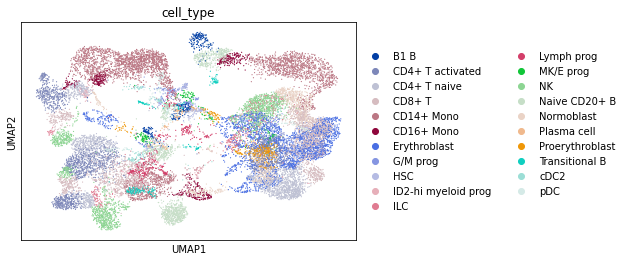

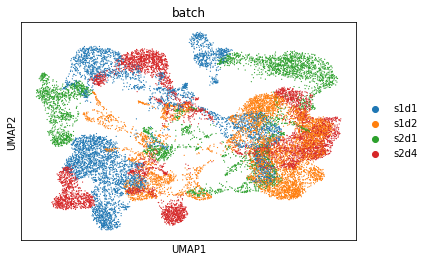

In [8]:
sc.pl.umap(adata_gex, color='cell_type')
sc.pl.umap(adata_gex, color='batch')

Note, for the `.obs["batch"]` metadata, the symbol represents the site and donor in the following format: `s1d1` for site 1, donor 1.

#### Visualizing ATAC

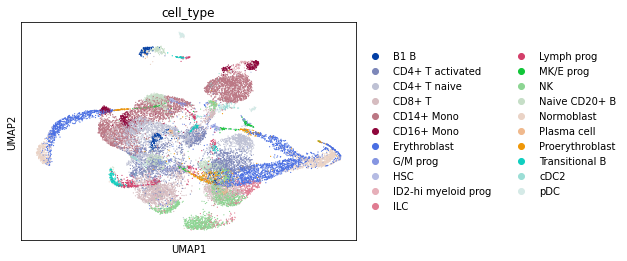

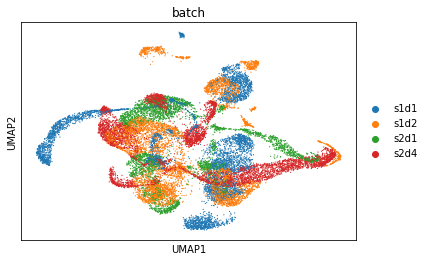

In [9]:
sc.pl.umap(adata_atac, color='cell_type')
sc.pl.umap(adata_atac, color='batch')

## Simple modality prediction

Task 1 of the competition is Modality Prediction. A full description of the task is available on the [Task Documentation](https://openproblems.bio/neurips_docs/about_tasks/task1_modality_prediction/).

Simply put, the goal is to take one modality as input and predict the other. Methods are given some training data in which modality 1 and modality 2 are known, and then a set of cells where only modality 1 is provided.

The censored training data for Phase 1 will be released on September 17, 2021. For now, you can make your own train / validation split in this notebook.

### Creating test / validation split

Let's start by using `s2d4` as our hold out sample.

In [11]:
train_cells = adata_gex.obs_names[adata_gex.obs["batch"] != "s2d4"]
test_cells  = adata_gex.obs_names[adata_gex.obs["batch"] == "s2d4"]

As we can see from the Task 1 documentation, methods for task one should expect the following input:
* `input_train_mod1`
* `input_train_mod2`
* `input_test_mod1`

Metrics then expect as input:
* `true_test_mod2`
* `pred_test_mod2`

With that, let's subset our data into these expected objects focusing on the subtask of predicting GEX from ATAC. 

In [ ]:
# This will get passed to the method
input_train_mod1 = adata_atac[train_cells]
input_train_mod2 = adata_gex[train_cells]
input_test_mod1 =  adata_atac[test_cells]

# This will get passed to the metric
true_test_mod2 =  adata_gex[test_cells]

### RMSE Metric

The metric for task 1 is RMSE on the `adata.layers["log_norm"]` data.

In [ ]:
def calculate_rmse(true_test_mod2, pred_test_mod2):
    if pred_test_mod2.var["feature_types"][0] == "GEX":
        return  mean_squared_error(true_test_mod2.layers["log_norm"].toarray(), pred_test_mod2.X, squared=False)
    else:
        raise NotImplementedError("Only set up to calculate RMSE for GEX data")

### Method

Let's try a method that runs linear regression on PCA transformed data before projecting the data back to the feature space.

In [ ]:
def baseline_linear(input_train_mod1, input_train_mod2, input_test_mod1):
    '''Baseline method training a linear regressor on the input data'''
    input_mod1 = ad.concat(
        {"train": input_train_mod1, "test": input_test_mod1},
        axis=0,
        join="outer",
        label="group",
        fill_value=0,
        index_unique="-", 
    )
    
    # Binarize ATAC 
    if input_train_mod1.var["feature_types"][0] == "ATAC":
        input_mod1.X[input_mod1.X > 1] = 1
    elif input_train_mod2.var["feature_types"][0] == "ATAC":
        input_train_mod2.X[input_mod1.X > 1] = 1
    
    # Do PCA on the input data
    logging.info('Performing dimensionality reduction on modality 1 values...')
    embedder_mod1 = TruncatedSVD(n_components=50)
    mod1_pca = embedder_mod1.fit_transform(input_mod1.X)
    
    logging.info('Performing dimensionality reduction on modality 2 values...')
    embedder_mod2 = TruncatedSVD(n_components=50)
    mod2_pca = embedder_mod2.fit_transform(input_train_mod2.layers["log_norm"])
    
    # split dimred mod 1 back up for training
    X_train = mod1_pca[input_mod1.obs['group'] == 'train']
    X_test = mod1_pca[input_mod1.obs['group'] == 'test']
    y_train = mod2_pca
    
    assert len(X_train) + len(X_test) == len(mod1_pca)
    
    logging.info('Running Linear regression...')
    
    reg = LinearRegression()
    
    # Train the model on the PCA reduced modality 1 and 2 data
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    # Project the predictions back to the modality 2 feature space
    y_pred = y_pred @ embedder_mod2.components_
    
    pred_test_mod2 = ad.AnnData(
        X = y_pred,
        obs = input_test_mod1.obs,
        var = input_train_mod2.var,
    
    )
    
    # Add the name of the method to the result
    pred_test_mod2.uns["method"] = "linear"
    
    return pred_test_mod2

Now, for comparison, let's create a simple dummy method that simply returns the mean for the input modality 2 data. This method returns an identical prediction for all cells and ignores the modality 1 information altogether.

In [ ]:
def baseline_mean(input_train_mod1, input_train_mod2, input_test_mod1):
    '''Dummy method that predicts mean(input_train_mod2) for all cells'''
    logging.info('Calculate mean of the training data modality 2...')
    y_pred = np.repeat(input_train_mod2.layers["log_norm"].mean(axis=0).reshape(-1,1).T, input_test_mod1.shape[0], axis=0)
    
    # Prepare the ouput data object
    pred_test_mod2 = ad.AnnData(
        X=y_pred,
        obs=input_test_mod1.obs,
        var=input_train_mod2.var,
    )
    
    pred_test_mod2.uns["method"] = "mean"

    return pred_test_mod2

#### Run comparison

Let's run the simple and dummy method side-by-side and compare performance.

In [ ]:
for method in [baseline_linear, baseline_mean]:
    # Run prediction
    pred_test_mod2 = method(input_train_mod1, input_train_mod2, input_test_mod1)
    # Calculate RMSE
    rmse = calculate_rmse(true_test_mod2, pred_test_mod2)
    # Print results
    print(f'{pred_test_mod2.uns["method"]} had a RMSE of {rmse:.4f}')

As expected, the linear model does better than the dummy method. But not by much! This has to do with batch effect present in the data. We'll provide some more information about this batch effect when we officially launch the competition. For now, we encourage competitors to consult the batch correction literature for strategies to mitigate this technical noise. [Lucken 2021](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2) is a good starting place.

Now the challenge is up to you! Can you do better than this baseline?